In [1]:
%pylab inline

import matplotlib.pyplot as plt
import six.moves.cPickle as pickle
import gzip
import os
import sys
import timeit

import numpy as np

import theano
import theano.tensor as T
import matplotlib.pyplot as plt
import csv
import pandas as pd
import six.moves.cPickle as pickle

Populating the interactive namespace from numpy and matplotlib


In [108]:
# Load MNIST dataset
dataset='mnist.pkl.gz'
with gzip.open(dataset, 'rb') as f:
        try:
            train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
        except:
            train_set, valid_set, test_set = pickle.load(f)

In [109]:
print(len(train_set[0][0]))
print(shape(train_set[1]))

784
(50000,)


In [110]:
batch_size = 256  # Size of minibatch
n_train_batches = shape(train_set[0])[0] // batch_size
n_valid_batches = shape(valid_set[0])[0] // batch_size
n_test_batches = shape(test_set[0])[0] // batch_size

In [111]:
# Declare Theano symbolic variables
x = T.dmatrix("x")
y = T.lvector("y")

In [112]:
# initialize the weight vector w randomly
#
# this and the following bias variable b
# are shared so they keep their values
# between training iterations (updates)
w = theano.shared(np.random.randn(len(train_set[0][0]), len(np.unique(train_set[1]))),
                name='w',borrow=True)

In [113]:
# initialize the bias term
b = theano.shared(value=numpy.zeros((len(np.unique(train_set[1])),)),
            name='b',borrow=True)

In [114]:
print("Initial model:")
print(w.get_value())
print(b.get_value())

Initial model:
[[ 0.65538523 -0.13979254  0.65265932 ...,  1.64312998 -0.54575824
   0.08941548]
 [ 0.92287053 -0.01076872  0.4052424  ...,  1.04279573  0.02905841
  -1.10207515]
 [ 1.51239859  0.83715661 -0.07232577 ...,  0.27079049 -2.01168585
  -0.83924153]
 ..., 
 [-0.37490001  1.36867883  0.32064766 ...,  0.21604199  1.46796592
  -0.69053784]
 [-0.7534331   1.40013677  1.03395916 ...,  0.5986936  -0.21413467
   0.34948113]
 [-0.19601581 -1.80756007 -0.98351946 ..., -1.25609538  0.95321336
   0.923801  ]]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [115]:
# Construct Theano expression graph
lambd = 0.001 # L2 regularization factor
p_y_given_x = T.nnet.softmax(T.dot(x, w) + b)   # Probability that target belongs to class i
prediction = T.argmax(p_y_given_x, axis=1)      # The prediction of the model (class whose probability is maximal)
#T.mean(T.neq(pred,train_set[1][index * batch_size: (index + 1) * batch_size]))
loss = -T.mean(T.log(p_y_given_x)[T.arange(y.shape[0]), y])  # Loss function
cost = loss.mean() + lambd * (w ** 2).sum()      # The cost to minimize
gw = T.grad(cost=cost, wrt=w)
gb = T.grad(cost=cost, wrt=b)                   # Compute the gradient of the cost
                                                # w.r.t weight vector w and
                                                # bias term b
                                                # (we shall return to this in a
                                                # following section of this tutorial)

In [116]:
from theano import function
# Function to count errors
aa = T.dvector('aa')
bb = T.dvector('bb')
cc = T.mean(T.neq(aa, bb))
f_err = function([aa, bb], cc)

In [117]:
# Compile
eta = 0.1
train = theano.function(
          inputs=[x,y],
          outputs=[prediction, cost],
          updates=((w, w - eta * gw), (b, b - eta * gb)),name='train')
validate = theano.function(
          inputs=[x,y],
          outputs=[prediction, cost],name='validate')
test = theano.function(
          inputs=[x,y],
          outputs=[prediction, cost],name='test')
predict = theano.function(inputs=[x], outputs=prediction, name='predict')


In [118]:
n_epochs = 70

13650
137
137


(0.0, 13600.0, 0.39196225836067267, 20.66975615024279)

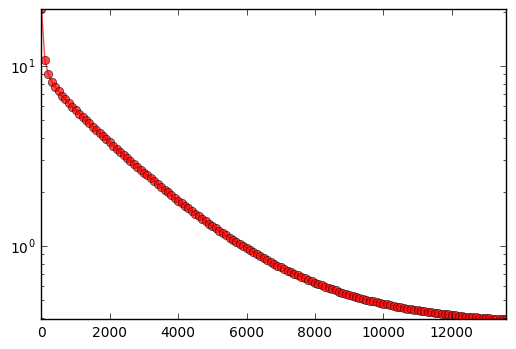

In [119]:
# Train
error_train = []
error_valid = []
error_test = []
for i in range(n_epochs):
    
    for index in range(n_train_batches):
        
        pred, err = train(train_set[0][index * batch_size: (index + 1) * batch_size], \
                          train_set[1][index * batch_size: (index + 1) * batch_size])
        error_train.append(err)
        
        errores = []
        errores1 = []
        if ((i*n_train_batches+index)%100 == 0):
            for j in range(n_valid_batches):
                pred_val, err_val = validate(valid_set[0][j * batch_size: (j + 1) * batch_size], \
                              valid_set[1][j * batch_size: (j + 1) * batch_size])
                errores.append(err_val)
            this_error = np.mean(errores)
            error_valid.append(this_error)
            
            for h in range(n_test_batches):
                pred_test, err_test = test(test_set[0][h * batch_size: (h + 1) * batch_size], \
                              test_set[1][h * batch_size: (h + 1) * batch_size])
                errores1.append(err_test)
            this_error1 = np.mean(errores1)
            error_test.append(this_error1)
            
print(len(error_train))
print(len(error_valid))
print(len(error_test))


#print(len(error_test))
avg_train_loss = []
for i in range(int(n_epochs*n_train_batches/100)):
    avg_train_loss.append(median(error_train[i*100:i*100+100]))


plt.plot(100*arange(len(error_valid)),error_valid,marker='o',color='red',alpha=0.7)
#plt.plot(50+100*arange(len(avg_train_loss)),avg_train_loss,marker='^',color='orange',alpha=0.7)

plt.yscale('log')
plt.axis('tight')

(0.293, 0.297)

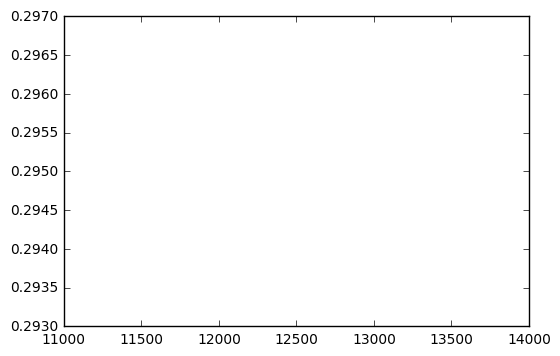

In [120]:
plt.plot(100*arange(len(error_valid)),error_valid,marker='o',color='red',alpha=0.7)

#plt.plot(100*arange(len(error_valid)),error_no_val,marker='o',color='blue',alpha=0.7)
#plt.plot(100*arange(len(error_valid)),np.array(error_val_01),marker='o',color='red',alpha=0.7)
#plt.plot(100*arange(len(error_valid)),error_val_1,marker='o',color='orange',alpha=0.7)
#plt.plot(100*arange(len(error_valid)),error_val_001,marker='o',color='green',alpha=0.7)
#plt.plot(100*arange(len(error_valid)),error_val_0001,marker='o',color='pink',alpha=0.7)

#plt.plot(50+100*arange(len(avg_train_loss)),np.array(avg_train_loss)-0.03,marker='^',color='orange',alpha=0.7)

plt.xlim(11000,14000)
plt.ylim(0.293,0.297)
#plt.yscale('log')
#plt.axis('tight')

#error_val_0001 = error_valid

In [121]:
print("target values for D:")
print(test_set[1])
print("prediction on D:")
print(predict(test_set[0]))
print('Test error = ',100.*f_err(test_set[1],predict(test_set[0])))

target values for D:
[7 2 1 ..., 4 5 6]
prediction on D:
[7 2 1 ..., 4 5 6]
Test error =  8.2
